In [1]:
import argparse
import datetime
import os
import traceback
import cv2
import numpy as np
import torch
import yaml
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.autonotebook import tqdm
from glob import glob
from backbone import EfficientDetBackbone
from efficientdet.dataset import HmDataset, Resizer, Normalizer, Augmenter, collater, get_bbox
from efficientdet.loss import FocalLoss
from utils.sync_batchnorm import patch_replication_callback
from utils.utils import replace_w_sync_bn, CustomDataParallel, get_last_weights, init_weights, boolean_string
from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess
from torch.backends import cudnn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL.Image as Image
import math
from tensorboardX import SummaryWriter
from mean_average_precision import MeanAveragePrecision
import csv
import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline
#torch.autograd.set_detect_anomaly(True)

# Hyperparameter

In [2]:
opt = {
    'project':'hemorrhage_binary',
    'compound_coef':0,
    'num_workers':12,
    'batch_size':12*torch.cuda.device_count(),
    'test_batch_size':1,
    'head_only':False,
    'lr':1e-3,
    'optim':'adamw',
    'num_epochs':600,
    'val_interval':1,
    'save_interval':1000,
    'es_min_delta':0.0,
    'es_patience':0.0,
    'data_path':'../Hemorrhage_dataset/',
    'log_path':'logs/',
    'load_weights':'weights/efficientdet-d0.pth',
    'saved_path':'logs/',
    'debug':False,
}

class Params:
    def __init__(self, project_file):
        self.params = yaml.safe_load(open(project_file).read())

    def __getattr__(self, item):
        return self.params.get(item, None)

params = Params(f'projects/'+opt['project']+'.yml')

if params.num_gpus == 0:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
else:
    torch.manual_seed(42)

opt['saved_path'] = opt['saved_path'] + f'/{params.project_name}/d0/'
opt['log_path'] = opt['log_path'] + f'/{params.project_name}/tensorboard/'
os.makedirs(opt['log_path'], exist_ok=True)
os.makedirs(opt['saved_path'], exist_ok=True)

training_params = {'batch_size': opt['batch_size'],
                   'shuffle': True,
                   'drop_last': True,
                   'collate_fn': collater,
                   'num_workers': opt['num_workers']}

val_params = {'batch_size': opt['batch_size'],
              'shuffle': False,
              'drop_last': True,
              'collate_fn': collater,
              'num_workers': opt['num_workers']}

test_params = {'batch_size': opt['test_batch_size'],
              'shuffle': False,
              'drop_last': True,
              'collate_fn': collater,
              'num_workers': opt['num_workers']}

input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]

# Utils

In [3]:
class ModelWithLoss(nn.Module):
    def __init__(self, model, debug=False):
        super().__init__()
        self.criterion = FocalLoss()
        self.model = model
        self.debug = debug

    def forward(self, imgs, annotations, obj_list=None):
        _, regression, classification, anchors = self.model(imgs)
        if self.debug:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations,
                                                imgs=imgs, obj_list=obj_list)
        else:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations)
        return cls_loss, reg_loss

def save_checkpoint(model, name):
    if isinstance(model, CustomDataParallel):
        torch.save(model.module.model.state_dict(), os.path.join(opt['saved_path'], name))
    else:
        torch.save(model.model.state_dict(), os.path.join(opt['saved_path'], name))

In [4]:
def visualization(img_path, weight_path=opt['load_weights'], threshold=0.2, iou_threshold=0.2):
    
    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, len(params.obj_list))]

    fig, ax0 = plt.subplots(figsize=(5,5))
    
    compound_coef = 0
    force_input_size = None  # set None to use default size

    use_cuda = True
    use_float16 = False
    cudnn.fastest = True
    cudnn.benchmark = True

    # tf bilinear interpolation is different from any other's, just make do
    input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
    input_size = input_sizes[opt['compound_coef']] if force_input_size is None else force_input_size
    ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size, mean=params.mean, std=params.std)
    
    if use_cuda:
        x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
    else:
        x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

    x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

    model_vis = EfficientDetBackbone(num_classes=len(params.obj_list), compound_coef=opt['compound_coef'],
                                 ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))
    
    try:
        model_vis.load_state_dict(torch.load(weight_path))
    except:
        print('The rest of the weights should be loaded already.')
        
    model_vis.requires_grad_(False)
    model_vis.eval()

    if use_cuda:
        model_vis = model_vis.cuda()
    if use_float16:
        model_vis = model_vis.half()

    with torch.no_grad():
        features, regression, classification, anchors = model_vis(x)

        regressBoxes = BBoxTransform()
        clipBoxes = ClipBoxes()

        out = postprocess(x,
                          anchors, regression, classification,
                          regressBoxes, clipBoxes,
                          threshold, iou_threshold)

    out = invert_affine(framed_metas, out)

    for i in range(len(ori_imgs)):
        if len(out[i]['rois']) == 0:
            continue
        ori_imgs[i] = ori_imgs[i].copy()
        for j in range(len(out[i]['rois'])):
            (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
            obj = params.obj_list[out[i]['class_ids'][j]]
            score = float(out[i]['scores'][j])
                       
            color = colors[out[i]['class_ids'][j]]
            bbox = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor="none")
            
            ax0.add_patch(bbox)
            # Add label
            ax0.text(
                x1,
                y2,
                s="{} {:.3f}".format(obj,score),
                color="white",
                verticalalignment="top", 
                bbox={"color": color, "pad": 0},   
            )

    ax0.imshow(ori_imgs[i])
    ax0.axis("off")

In [5]:
def save_result(image_paths, number, weight_path=opt['load_weights'], threshold=0.2, iou_threshold=0.2):
    # Bounding-box colors
    for num in range(0,number):
        img_path = image_paths[num]

        cmap = plt.get_cmap("tab20b")
        colors = [cmap(i) for i in np.linspace(0, 1, len(params.obj_list))]

        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,12))

        cudnn.fastest = True
        cudnn.benchmark = True

        # tf bilinear interpolation is different from any other's, just make do
        input_size = input_sizes[opt['compound_coef']]
        ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size, mean=params.mean, std=params.std)

        if torch.cuda.is_available():
            x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
        else:
            x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

        x = x.to(torch.float32).permute(0, 3, 1, 2)

        model_eval = EfficientDetBackbone(num_classes=len(params.obj_list), compound_coef=opt['compound_coef'],
                                     ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))

        try:
            model_eval.load_state_dict(torch.load(weight_path))
        except:
            print('The rest of the weights should be loaded already.')

        model_eval.requires_grad_(False)
        model_eval.eval()

        if torch.cuda.is_available():
            model_eval = model_eval.cuda()
        if use_float16:
            model_eval = model_eval.half()

        with torch.no_grad():
            features, regression, classification, anchors = model_eval(x)

            regressBoxes = BBoxTransform()
            clipBoxes = ClipBoxes()

            out = postprocess(x,
                              anchors, regression, classification,
                              regressBoxes, clipBoxes,
                              threshold, iou_threshold)

        out = invert_affine(framed_metas, out)

        for i in range(len(ori_imgs)):
            if len(out[i]['rois']) == 0:
                continue
            ori_imgs[i] = ori_imgs[i].copy()
            for j in range(len(out[i]['rois'])):
                (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
                obj = params.obj_list[out[i]['class_ids'][j]]
                score = float(out[i]['scores'][j])

                color = colors[out[i]['class_ids'][j]]
                bbox = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor="none")

                ax0.add_patch(bbox)
                # Add label
                ax0.text(
                    x1,
                    y2,
                    s="{} {:.3f}".format(obj,score),
                    color="white",
                    verticalalignment="top", 
                    bbox={"color": color, "pad": 0},   
                )
        # Get specific val images
        data = test_set.__getitem__(num) # Convert to 4d tensor (BxNxHxW)
        test_image = data['img'].unsqueeze(0)
        test_image = ((test_image - test_image.min()) / (test_image.max() - test_image.min()))

        for i in range(0,data['annot'].shape[0]):
            [x1,y1,x2,y2,cls] = data['annot'][i].numpy()
            color = colors[int(cls)]
            bbox = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor="none")
            ax1.add_patch(bbox)
            # Add label
            ax1.text(
                x1,
                y2,
                s=params.obj_list[int(cls)],
                color="white",
                verticalalignment="top", 
                bbox={"color": color, "pad": 0},   
            )

        ax0.imshow(ori_imgs[0])
        ax0.set_title('Prediction')
        ax0.axis('off')
        ax1.imshow(test_image[0])
        ax1.set_title('Ground truth')
        ax1.axis('off')
        fig.savefig('./test/hemorrhage/result_{}'.format(num))

In [6]:
def eval_bbox(image_paths, mask_paths, weight_path=opt['load_weights'], cls_num=1, threshold=0.2, iou_threshold=0.2):
    
    # create metric_fn
    metric_fn = MeanAveragePrecision(num_classes=len(params.obj_list))
    
    compound_coef = 0
    force_input_size = None  # set None to use default size

    use_cuda = True
    use_float16 = False
    cudnn.fastest = True
    cudnn.benchmark = True

    model_eval = EfficientDetBackbone(num_classes=len(params.obj_list), compound_coef=opt['compound_coef'],
                                 ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))
    
    try:
        model_eval.load_state_dict(torch.load(weight_path))
    except:
        print('The rest of the weights should be loaded already.')
        
    model_eval.requires_grad_(False)
    model_eval.eval()

    if use_cuda:
        model_eval = model_eval.cuda()
    if use_float16:
        model_eval = model_eval.half()    
    
    # tf bilinear interpolation is different from any other's, just make do
    input_size = input_sizes[opt['compound_coef']] if force_input_size is None else force_input_size
    
    step = 1
    
    with torch.no_grad():
        for image_path, mask_path in zip(image_paths, mask_paths):
            
            
            preds = np.zeros((0,6))
            gts = np.zeros((0,7))

            ori_imgs, framed_imgs, framed_metas = preprocess(
                image_path, max_size=input_sizes[opt['compound_coef']], mean=params.mean, std=params.std)
            
            mask = np.array(Image.open(mask_path))
            annots = get_bbox(mask, cls_num)
            for annot in annots:
                gts = np.append(gts, [[annot[0],annot[1],annot[2],annot[3],annot[4],0,0]], axis=0)
            
            if use_cuda:
                x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
            else:
                x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

            x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

            features, regression, classification, anchors = model_eval(x)

            regressBoxes = BBoxTransform()
            clipBoxes = ClipBoxes()

            out = postprocess(x,
                              anchors, regression, classification,
                              regressBoxes, clipBoxes,
                              threshold, iou_threshold)

            out = invert_affine(framed_metas, out)

            for i in range(len(ori_imgs)):
                if len(out[i]['rois']) == 0:
                    continue
                for j in range(len(out[i]['rois'])):
                    (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
                    obj = params.obj_list[out[i]['class_ids'][j]]
                    score = float(out[i]['scores'][j])
                    preds = np.append(preds, [[x1,y1,x2,y2,out[i]['class_ids'][j],score]], axis=0)
                    
            # add some samples to evaluation
            metric_fn.add(preds, gts)
                        
            if step%(len(image_paths)/20)==0:
                
                AR = []
                AR05 = []
                AR10 = []
                AR25 = []
                AR50 = []
                AR75 = []

                for cls in range(len(params.obj_list)):
                    if not(math.isnan(metric_fn.value(iou_thresholds=0.05)[0.05][cls]['recall'].mean())):
                        AR05.append(metric_fn.value(iou_thresholds=0.05)[0.05][cls]['recall'].mean())
                    if not(math.isnan(metric_fn.value(iou_thresholds=0.1)[0.1][cls]['recall'].mean())):
                        AR10.append(metric_fn.value(iou_thresholds=0.1)[0.1][cls]['recall'].mean())
                    if not(math.isnan(metric_fn.value(iou_thresholds=0.25)[0.25][cls]['recall'].mean())):
                        AR25.append(metric_fn.value(iou_thresholds=0.25)[0.25][cls]['recall'].mean())
                    if not(math.isnan(metric_fn.value(iou_thresholds=0.5)[0.5][cls]['recall'].mean())):
                        AR50.append(metric_fn.value(iou_thresholds=0.5)[0.5][cls]['recall'].mean())
                    if not(math.isnan(metric_fn.value(iou_thresholds=0.75)[0.75][cls]['recall'].mean())):
                        AR75.append(metric_fn.value(iou_thresholds=0.75)[0.75][cls]['recall'].mean())

                AR05 = np.array(AR05).mean()
                AR10 = np.array(AR10).mean()
                AR25 = np.array(AR25).mean()
                AR50 = np.array(AR50).mean()    
                AR75 = np.array(AR75).mean()

                for cls in range(len(params.obj_list)):
                    for thr in np.arange(0.5, 1.0, 0.05):
                        if not(math.isnan(metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05))[thr][cls]['recall'].mean())):
                            AR.append(metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05))[thr][cls]['recall'].mean()) 
                AR = np.array(AR).mean()
                
                print(
                   'Images: {}/{}  AP: {:.3f} AP05 {:.3f} AP10: {:.3f} AP25: {:.3f} AP50: {:.3f} AP75: {:.3f}\t\t\t\t\t\
                    AR: {:.3f} AR05: {:.3f} AR10: {:.3f} AR25: {:.3f} AR50: {:.3f} AR75: {:.3f}\r'.format(
                       step, len(image_paths),
                       metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05))['mAP'],
                       metric_fn.value(iou_thresholds=0.05)['mAP'], metric_fn.value(iou_thresholds=0.1)['mAP'],
                       metric_fn.value(iou_thresholds=0.25)['mAP'], metric_fn.value(iou_thresholds=0.5)['mAP'],
                       metric_fn.value(iou_thresholds=0.75)['mAP'],
                       AR, AR05, AR10, AR25, AR50, AR75), end="")
                
            step+=1
            
    return metric_fn

In [14]:
def eval_class(image_paths, num_image, weight_path=opt['load_weights'], threshold=0.2, iou_threshold=0.2):
    # Bounding-box colors
    
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    obj_list = [i for i in range(len(params.obj_list))]
    eps = 1e-10
    
    for num in range(0,num_image):
        
        obj_pred = []
        obj_gt = []
        
        img_path = image_paths[num]

        cudnn.fastest = True
        cudnn.benchmark = True

        # tf bilinear interpolation is different from any other's, just make do
        input_size = input_sizes[opt['compound_coef']]
        ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size, mean=params.mean, std=params.std)

        if torch.cuda.is_available():
            x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
        else:
            x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

        x = x.to(torch.float32).permute(0, 3, 1, 2)

        model_eval = EfficientDetBackbone(num_classes=len(params.obj_list), compound_coef=opt['compound_coef'],
                                     ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))

        try:
            model_eval.load_state_dict(torch.load(weight_path))
        except:
            print('The rest of the weights should be loaded already.')

        model_eval.requires_grad_(False)
        model_eval.eval()

        if torch.cuda.is_available():
            model_eval = model_eval.cuda()

        with torch.no_grad():
            features, regression, classification, anchors = model_eval(x)

            regressBoxes = BBoxTransform()
            clipBoxes = ClipBoxes()

            out = postprocess(x,
                              anchors, regression, classification,
                              regressBoxes, clipBoxes,
                              threshold, iou_threshold)

        out = invert_affine(framed_metas, out)

        for i in range(len(ori_imgs)):
            if len(out[i]['rois']) == 0:
                continue
            ori_imgs[i] = ori_imgs[i].copy()
            for j in range(len(out[i]['rois'])):
                obj_pred.append(out[i]['class_ids'][j])

        # Get specific val images
        data = test_set.__getitem__(num) # Convert to 4d tensor (BxNxHxW)

        for i in range(0,data['annot'].shape[0]):
            [x1,y1,x2,y2,cls] = data['annot'][i].numpy()
            obj_gt.append(int(cls))
        
        if len(obj_pred)>0:
            for i in range(len(obj_pred)):
                if obj_pred[i] in obj_gt:
                    tp += 1
                else: fp += 1
        
        if len(obj_gt)>0:
            for i in range(len(obj_gt)):
                if obj_gt[i] not in obj_pred:
                    fn += 1
        
        not_gt = [x for x in obj_list if x not in obj_gt]
        if len(not_gt)>0:
            for i in not_gt:
                if i not in obj_pred:
                    tn += 1
    
        print(
           'Images: {}/{}  Precision: {:.3f} Recall: {:.3f} Specificity: {:.3f} Accuracy: {:.3f} F1 score: {:.3f}\r'.format(
               num+1, num_image,
               tp/(tp+fp+eps),
               tp/(tp+fn+eps),
               tn/(tn+fp+eps),
               (tp+tn)/(tp+tn+fp+fn+eps),
               (2*tp)/(2*tp+fp+fn+eps)), end="")    

    return tp, fp, tn, fn

# Model

In [8]:
model = EfficientDetBackbone(num_classes=len(params.obj_list), compound_coef=opt['compound_coef'],
                             ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))

# load last weights
if opt['load_weights'] is not None:
    if opt['load_weights'].endswith('.pth'):
        weights_path = opt['load_weights']
    else:
        weights_path = get_last_weights(opt['saved_path'])
    try:
        last_step = int(os.path.basename(weights_path).split('_')[-1].split('.')[0])
    except:
        last_step = 0

    try:
        ret = model.load_state_dict(torch.load(weights_path), strict=False)
    except RuntimeError as e:
        print(f'[Warning] Ignoring {e}')
        print(
            '[Warning] Don\'t panic if you see this, this might be because you load a pretrained weights with different number of classes. The rest of the weights should be loaded already.')

    print(f'[Info] loaded weights: {os.path.basename(weights_path)}, resuming checkpoint from step: {last_step}')
else:
    last_step = 0
    print('[Info] initializing weights...')
    init_weights(model)

# freeze backbone if train head_only
if opt['head_only']:
    def freeze_backbone(m):
        classname = m.__class__.__name__
        for ntl in ['EfficientNet', 'BiFPN']:
            if ntl in classname:
                for param in m.parameters():
                    param.requires_grad = False

    model.apply(freeze_backbone)
    print('[Info] freezed backbone')

# https://github.com/vacancy/Synchronized-BatchNorm-PyTorch
# apply sync_bn when using multiple gpu and batch_size per gpu is lower than 4
#  useful when gpu memory is limited.
# because when bn is disable, the training will be very unstable or slow to converge,
# apply sync_bn can solve it,
# by packing all mini-batch across all gpus as one batch and normalize, then send it back to all gpus.
# but it would also slow down the training by a little bit.
if params.num_gpus > 1 and opt.batch_size // params.num_gpus < 4:
    model.apply(replace_w_sync_bn)
    use_sync_bn = True
else:
    use_sync_bn = False

writer = SummaryWriter(opt['log_path'] + f'/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/')

# warp the model with loss function, to reduce the memory usage on gpu0 and speedup
model = ModelWithLoss(model, debug=opt['debug'])

if params.num_gpus > 0:
    model = model.cuda()
    if params.num_gpus > 1:
        model = CustomDataParallel(model, params.num_gpus)
        if use_sync_bn:
            patch_replication_callback(model)

[Warning] Ignoring Error(s) in loading state_dict for EfficientDetBackbone:
	size mismatch for classifier.header.pointwise_conv.conv.weight: copying a param with shape torch.Size([810, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([9, 64, 1, 1]).
	size mismatch for classifier.header.pointwise_conv.conv.bias: copying a param with shape torch.Size([810]) from checkpoint, the shape in current model is torch.Size([9]).
[Warning] Don't panic if you see this, this might be because you load a pretrained weights with different number of classes. The rest of the weights should be loaded already.
[Info] loaded weights: efficientdet-d0.pth, resuming checkpoint from step: 0


# Preprocessing

In [9]:
image_paths = glob(opt['data_path'] + 'image/*.png')
image_list = os.listdir(opt['data_path'] + 'image')
mask_paths = [image_paths[i][:22] + 'label_binary/' + image_list[i][:-8] + '_label.png' for i in range(len(image_paths))]

train_image_paths = image_paths[20000:]
train_mask_paths = mask_paths[20000:]

val_image_paths = image_paths[:10000]
val_mask_paths = mask_paths[:10000]

test_image_paths = image_paths[10000:20000]
test_mask_paths = mask_paths[10000:20000]

print('Train images: {}   Val images: {}   Test images: {}'.format(len(train_image_paths),len(val_image_paths),len(test_image_paths)))

Train images: 86225   Val images: 10000   Test images: 10000


In [10]:
training_set = HmDataset(train_image_paths, train_mask_paths, len(params.obj_list),
                           transform=transforms.Compose([Normalizer(mean=params.mean, std=params.std),
                                                         Augmenter(),
                                                         Resizer(input_sizes[opt['compound_coef']])]))
training_generator = DataLoader(training_set, **training_params)

val_set = HmDataset(val_image_paths, val_mask_paths, len(params.obj_list),
                      transform=transforms.Compose([Normalizer(mean=params.mean, std=params.std),
                                                    Resizer(input_sizes[opt['compound_coef']])]))
val_generator = DataLoader(val_set, **val_params)

test_set = HmDataset(test_image_paths, test_mask_paths, len(params.obj_list),
                      transform=transforms.Compose([Normalizer(mean=params.mean, std=params.std),
                                                    Resizer(input_sizes[opt['compound_coef']])]))
test_generator = DataLoader(test_set, **test_params)

In [9]:
for i, data in enumerate(val_generator):
    if i == 0:
        print(data['img'].shape, data['annot'].shape)
        break

torch.Size([12, 3, 512, 512]) torch.Size([12, 5, 5])


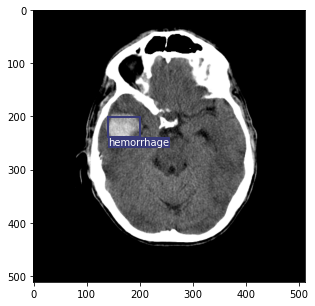

In [11]:
# Get specific val images
data = val_set.__getitem__(0) # Convert to 4d tensor (BxNxHxW)
val_image = data['img'].unsqueeze(0)
val_image = ((val_image - val_image.min()) / (val_image.max() - val_image.min()))
val_annot = data['annot']

cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, len(params.obj_list))]
fig, ax0 = plt.subplots(figsize=(5,5))
for i in range(0,data['annot'].shape[0]):
    [x1,y1,x2,y2,cls] = data['annot'][i].numpy()
    color = colors[int(cls)]
    bbox = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor="none")
    ax0.add_patch(bbox)
    # Add label
    ax0.text(
        x1,
        y2,
        s=params.obj_list[int(cls)],
        color="white",
        verticalalignment="top", 
        bbox={"color": color, "pad": 0},   
    )
    
ax0.imshow(val_image[0])
#ax0.axis('off')

# Visualization

The rest of the weights should be loaded already.


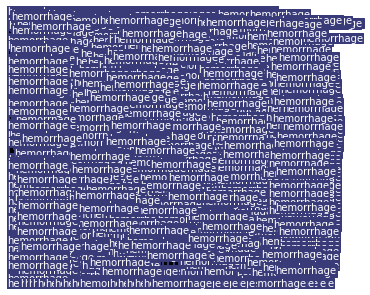

In [17]:
img_path = image_paths[0]
visualization(img_path)

# Optimizer

In [12]:
if opt['optim'] == 'adamw':
    optimizer = torch.optim.AdamW(model.parameters(), opt['lr'])
else:
    optimizer = torch.optim.SGD(model.parameters(), opt['lr'], momentum=0.9, nesterov=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

# Train

In [ ]:
epoch = 0
best_loss = 1e5
best_epoch = 0
step = max(0, last_step)
model.train()

num_iter_per_epoch = len(training_generator)
train_avg_losses = []
train_avg_cls_losses = []
train_avg_reg_losses = []
val_avg_losses = []
val_avg_cls_losses = []
val_avg_reg_losses = []

try:
    for epoch in range(opt['num_epochs']+1):
        last_epoch = step // num_iter_per_epoch
        if epoch < last_epoch:
            continue

        train_losses = []
        train_cls_losses = []
        train_reg_losses = []
        val_losses = []
        val_cls_losses = []
        val_reg_losses = []
        
        progress_bar = tqdm(training_generator)
        for iter, data in enumerate(progress_bar):
                
            imgs = data['img']
            annot = data['annot']

            if params.num_gpus == 1:
                # if only one gpu, just send it to cuda:0
                # elif multiple gpus, send it to multiple gpus in CustomDataParallel, not here
                imgs = imgs.cuda()
                annot = annot.cuda()
            
            optimizer.zero_grad()
            cls_loss, reg_loss = model(imgs, annot, obj_list=params.obj_list)
            cls_loss = cls_loss.mean()
            reg_loss = reg_loss.mean()

            loss = cls_loss + reg_loss
            if loss == 0 or not torch.isfinite(loss):
                continue

            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()

            train_losses.append(loss.item())
            train_cls_losses.append(cls_loss.item())
            train_reg_losses.append(reg_loss.item())
            
            progress_bar.set_description(
               'Step: {}. Epoch: {}/{}. Iteration: {}/{}. Cls loss: {:.5f}. Reg loss: {:.5f}. Total loss: {:.5f}'.format(
                   step, epoch, opt['num_epochs'], iter + 1, num_iter_per_epoch, cls_loss.item(),
                   reg_loss.item(), loss.item()))
            
            step += 1

            #if step % opt['save_interval'] == 0 and step > 0:
            #    save_checkpoint(model, 'efficientdet-d{}_{}_{}.pth'.format(opt['compound_coef'],epoch,step))
            #    print('checkpoint...')
        
        train_avg_loss = torch.mean(torch.FloatTensor(train_losses))
        train_avg_losses.append(train_avg_loss.item())
        train_avg_cls_loss = torch.mean(torch.FloatTensor(train_cls_losses))
        train_avg_cls_losses.append(train_avg_cls_loss.item())        
        train_avg_reg_loss = torch.mean(torch.FloatTensor(train_reg_losses))
        train_avg_reg_losses.append(train_avg_reg_loss.item())               
        
        writer.add_scalars('Loss', {'train': train_avg_loss}, epoch)
        writer.add_scalars('Regression_loss', {'train': train_avg_reg_loss}, epoch)
        writer.add_scalars('Classfication_loss', {'train': train_avg_cls_loss}, epoch)
        
        # log learning_rate
        current_lr = optimizer.param_groups[0]['lr']
        writer.add_scalar('learning_rate', current_lr, epoch)          

        scheduler.step(train_avg_loss)

        model.eval()
        with torch.no_grad():
            for iter, data in enumerate(val_generator):
                imgs = data['img']
                annot = data['annot']

                if params.num_gpus == 1:
                    # if only one gpu, just send it to cuda:0
                    # elif multiple gpus, send it to multiple gpus in CustomDataParallel, not here
                    imgs = imgs.cuda()
                    annot = annot.cuda()

                cls_loss, reg_loss = model(imgs, annot, obj_list=params.obj_list)
                cls_loss = cls_loss.mean()
                reg_loss = reg_loss.mean()
                
                loss = cls_loss + reg_loss

                if loss == 0 or not torch.isfinite(loss):
                    continue
                
                val_losses.append(loss.item())
                val_cls_losses.append(cls_loss.item())
                val_reg_losses.append(reg_loss.item())
                      
        val_avg_loss = torch.mean(torch.FloatTensor(val_losses))
        val_avg_losses.append(val_avg_loss.item())
        val_avg_cls_loss = torch.mean(torch.FloatTensor(val_cls_losses))
        val_avg_cls_losses.append(val_avg_cls_loss.item())
        val_avg_reg_loss = torch.mean(torch.FloatTensor(val_reg_losses))
        val_avg_reg_losses.append(val_avg_reg_loss.item())

        print(
            'Val. Epoch: {}/{}. Classification loss: {:1.5f}. Regression loss: {:1.5f}. Total loss: {:1.5f}'.format(
                epoch, opt['num_epochs'], val_avg_cls_loss.item(), val_avg_reg_loss.item(), val_avg_loss.item()))
        
        writer.add_scalars('Loss', {'val': val_avg_loss}, epoch)
        writer.add_scalars('Regression_loss', {'val': val_avg_reg_loss}, epoch)
        writer.add_scalars('Classfication_loss', {'val': val_avg_cls_loss}, epoch)
        
        if val_avg_loss + opt['es_min_delta'] < best_loss:
            best_loss = val_avg_loss
            best_epoch = epoch

            save_checkpoint(model, 'efficientdet-d{}_{}_{}.pth'.format(opt['compound_coef'],epoch,step))

        model.train()
        
        # Early stopping
        if epoch - best_epoch > opt['es_patience'] > 0:
            print('[Info] Stop training at epoch {}. The lowest loss achieved is {}'.format(epoch, best_loss))
            break
                
except KeyboardInterrupt:
    save_checkpoint(model, 'efficientdet-d{}_{}_{}.pth'.format(opt['compound_coef'], epoch, step))
    writer.close()
writer.close()    


Val. Epoch: 0/600. Classification loss: 0.31206. Regression loss: 1.64439. Total loss: 1.95645



Val. Epoch: 1/600. Classification loss: 0.30610. Regression loss: 1.61702. Total loss: 1.92312



Val. Epoch: 2/600. Classification loss: 0.34422. Regression loss: 1.61886. Total loss: 1.96307



Val. Epoch: 3/600. Classification loss: 0.31490. Regression loss: 1.57855. Total loss: 1.89345



Val. Epoch: 4/600. Classification loss: 0.35622. Regression loss: 1.79121. Total loss: 2.14743



Val. Epoch: 5/600. Classification loss: 0.36018. Regression loss: 1.73245. Total loss: 2.09262



Val. Epoch: 6/600. Classification loss: 0.37021. Regression loss: 1.65884. Total loss: 2.02905



Val. Epoch: 7/600. Classification loss: 0.26925. Regression loss: 1.51087. Total loss: 1.78012



Val. Epoch: 8/600. Classification loss: 0.27803. Regression loss: 1.47770. Total loss: 1.75573



Val. Epoch: 9/600. Classification loss: 0.38299. Regression loss: 1.78906. Total loss: 2.17204



Val. Epoch: 10/600. Classification loss: 0.28594. Regression loss: 1.42254. Total loss: 1.70849



Val. Epoch: 11/600. Classification loss: 0.26193. Regression loss: 1.46160. Total loss: 1.72353



Val. Epoch: 12/600. Classification loss: 0.26839. Regression loss: 1.41528. Total loss: 1.68367



Val. Epoch: 13/600. Classification loss: 0.33225. Regression loss: 1.70535. Total loss: 2.03760



Val. Epoch: 14/600. Classification loss: 0.28548. Regression loss: 1.44515. Total loss: 1.73063



Val. Epoch: 15/600. Classification loss: 0.26005. Regression loss: 1.41042. Total loss: 1.67047



Val. Epoch: 16/600. Classification loss: 0.27014. Regression loss: 1.45610. Total loss: 1.72624



Val. Epoch: 17/600. Classification loss: 0.25071. Regression loss: 1.41855. Total loss: 1.66926



Val. Epoch: 18/600. Classification loss: 0.26145. Regression loss: 1.42869. Total loss: 1.69013



Val. Epoch: 19/600. Classification loss: 0.27956. Regression loss: 1.44671. Total loss: 1.72627



Val. Epoch: 20/600. Classification loss: 0.26682. Regression loss: 1.41347. Total loss: 1.68030



Val. Epoch: 21/600. Classification loss: 0.27653. Regression loss: 1.43135. Total loss: 1.70788



Val. Epoch: 22/600. Classification loss: 0.26323. Regression loss: 1.41982. Total loss: 1.68305



Val. Epoch: 23/600. Classification loss: 0.37602. Regression loss: 1.86757. Total loss: 2.24359



Val. Epoch: 24/600. Classification loss: 0.27211. Regression loss: 1.46663. Total loss: 1.73874



Val. Epoch: 25/600. Classification loss: 0.25690. Regression loss: 1.41025. Total loss: 1.66715



Val. Epoch: 26/600. Classification loss: 0.25664. Regression loss: 1.40166. Total loss: 1.65830



Val. Epoch: 27/600. Classification loss: 0.32896. Regression loss: 1.63956. Total loss: 1.96852



Val. Epoch: 28/600. Classification loss: 0.47777. Regression loss: 2.03496. Total loss: 2.51273



Val. Epoch: 29/600. Classification loss: 0.27326. Regression loss: 1.43648. Total loss: 1.70974



Val. Epoch: 30/600. Classification loss: 0.28482. Regression loss: 1.52844. Total loss: 1.81325



Val. Epoch: 31/600. Classification loss: 0.26133. Regression loss: 1.42046. Total loss: 1.68178



Val. Epoch: 32/600. Classification loss: 0.31872. Regression loss: 1.60479. Total loss: 1.92351



Val. Epoch: 33/600. Classification loss: 0.26958. Regression loss: 1.42010. Total loss: 1.68968



Val. Epoch: 34/600. Classification loss: 0.27029. Regression loss: 1.47202. Total loss: 1.74231



Val. Epoch: 35/600. Classification loss: 0.27798. Regression loss: 1.44741. Total loss: 1.72539



Val. Epoch: 36/600. Classification loss: 0.46011. Regression loss: 1.73577. Total loss: 2.19589



Val. Epoch: 37/600. Classification loss: 0.27130. Regression loss: 1.47895. Total loss: 1.75026



Val. Epoch: 38/600. Classification loss: 0.29307. Regression loss: 1.47930. Total loss: 1.77237



Val. Epoch: 39/600. Classification loss: 0.51163. Regression loss: 2.29717. Total loss: 2.80880



Val. Epoch: 40/600. Classification loss: 0.26343. Regression loss: 1.46902. Total loss: 1.73245



Val. Epoch: 41/600. Classification loss: 0.27795. Regression loss: 1.45875. Total loss: 1.73670



Val. Epoch: 42/600. Classification loss: 0.34514. Regression loss: 1.67622. Total loss: 2.02136



Val. Epoch: 43/600. Classification loss: 0.55686. Regression loss: 1.96157. Total loss: 2.51843



Val. Epoch: 44/600. Classification loss: 0.42633. Regression loss: 1.62748. Total loss: 2.05381


# Restore Checkpoint

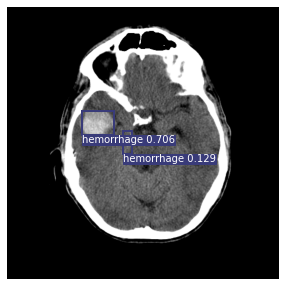

In [13]:
img_path = val_image_paths[0]
weight_path = "./logs/hemorrhage_binary/d0/efficientdet-d0_26_193995.pth"
visualization(img_path, weight_path, 0.1, 0.1)

In [ ]:
save_result(test_image_paths, weight_path, 1000, 0.1, 0.1) 

# Evaluation

In [35]:
metric_fn = eval_bbox(
    test_image_paths, test_mask_paths, weight_path, len(params.obj_list), 0.1, 0.1)

In [15]:
tp, fp, tn, fn = eval_class(test_image_paths, len(test_image_paths), weight_path, 0.1, 0.1)